# D&D Encounter Difficulty Calibration
## Evaluating the Data
**T. J. Johnson**

---

The goal of this notebook is to investigate the simulated outcomes from generating 10,000 battles of each of the possible encounter difficulties ('easy', 'medium', 'hard', and 'deadly').  The results were generated in the _Generate\_CSVs_ notebook, and represent the outcomes of battles between five first level player characters (PCs) and generic enemies, with challenge ratings between 0 and 3, in combinations which result in a total number of experience points within the bounds of the given encounter difficulty.  For more details on the simple simulation approach, see the repo README.  It is important that all of the results in this notebook be understood in light of the assumptions and simplifications we have made.

The notebook to generate the data also showed a quick look at the CSV file for 'easy' encounters.  We did a similar verification for the other encounters, not shown here, to convince ourselves that the output appears to be in line with what we expect.

We will start by loading in the CSV files.

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import pandas as pd
import seaborn as sns

In [3]:
#working assumption is that the CSV files are in the current directory
easy_df=pd.read_csv('Simulated_easy_10000battles.csv')
medium_df=pd.read_csv('Simulated_medium_10000battles.csv')
hard_df=pd.read_csv('Simulated_hard_10000battles.csv')
deadly_df=pd.read_csv('Simulated_deadly_10000battles.csv')

### Success or Failure

Perhaps the most straightforward way to evaluate "what does each difficulty rating mean" is to look at the expected percentage of encounters won or lost by the PCs.  Note, the simulation does not take into account death saving throws, instant kills, or the possibility that the PCs might choose to flee (and might be successful in doing so).

In [275]:
wins_df=pd.concat([pd.concat([easy_df,
                              pd.DataFrame({'difficulty':['easy']*10000})],axis=1),
                   pd.concat([medium_df,
                              pd.DataFrame({'difficulty':['medium']*10000})],axis=1),
                   pd.concat([hard_df,
                              pd.DataFrame({'difficulty':['hard']*10000})],axis=1),
                   pd.concat([deadly_df,
                              pd.DataFrame({'difficulty':['deadly']*10000})],axis=1)]).reset_index(drop=True)

wins_df.success=wins_df.success.apply(lambda s: 'Win' if s else 'Lose')

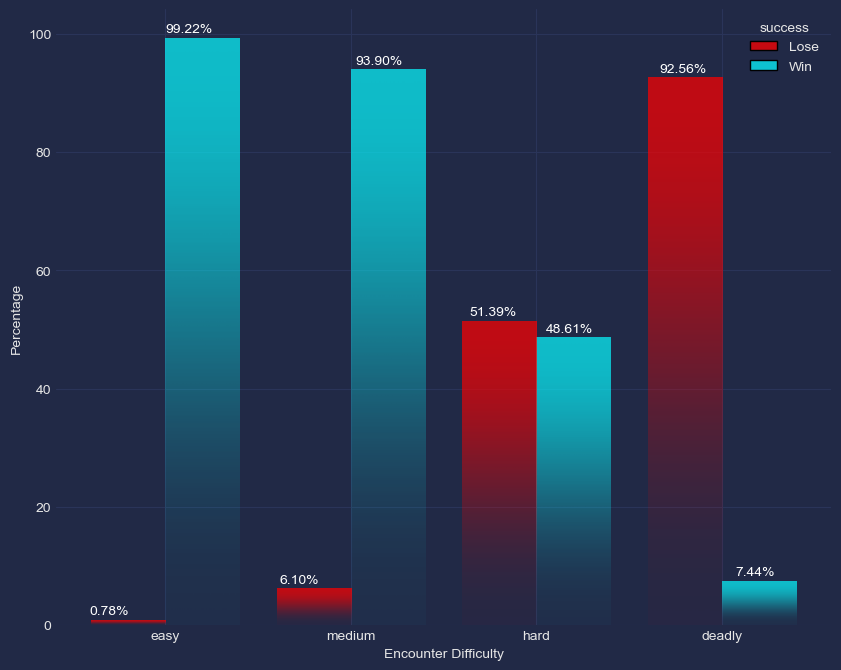

In [263]:
with plt.style.context('cyberpunk'):
    fig,ax=plt.subplots()
    fig.set_size_inches(10,8)
    ax=sns.histplot(x='difficulty',hue='success',data=wins_df,multiple='dodge',shrink=0.8,
           ax=ax,palette=['C4','C0'],stat='count',weights=1/100,common_norm=False,hue_order=['Lose','Win'])
    ax.set_xlabel('Encounter Difficulty')
    ax.set_ylabel('Percentage')
    
    #get fractions for percentages to add to plot
    percentages=[]
    percentages+=(easy_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(medium_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(hard_df.groupby('success').CRs.count()/10000).to_list()
    percentages+=(deadly_df.groupby('success').CRs.count()/10000).to_list()
    
    #due to how the patches are done when using a variable for hue
    #need to reorder percentages
    percentages=percentages[1:9:2]+percentages[0:8:2]
    
    for patch,percent in zip(ax.patches,percentages):
        ax.annotate(f'{percent:.2%}',xy=(patch.get_x()*1.025,patch.get_height()+1),
                   color='white')
    
    mplcyberpunk.add_bar_gradient(bars=ax.patches)
    
    plt.show()
    
    plt.savefig('plots/SuccessBarPlot_ByDifficulty_Percentages.png')

The results above aren't that surprising, with the win percentage getting lower as the difficulty increases.  In part, this may be due to the fixed rate at which the PCs use their "extras" (e.g., spell slots).  For a first pass, we assume a rate of 10% to use extras for increased damage, with a varying damage dealt to party threshold for using an extra to heal.  This might seem reasonable for a party thinking about conserving resources in the long term for an easy or medium difficulty encounter, but for hard and deadly, the PCs are likely to go for big damage early.  Creating logic for a variable rate at which extras is a future task after additional feedback is received.

This plot would suggest that the PCs should almost always run from a deadly encounter, but one wonders if we can dig deeper into the details of the encounters when they win or lose.  The rating system is open-ended for deadly, so we chose to cap deadly encounters at 3 times the minimum XP level and once we were above the minimum, there's always a 50% chance of stopping, if we didn't provide a limit on the number of enemies.

Let's dig more deeply into this question.